# Specify Cuda Device

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# import warnings; warnings.simplefilter('ignore')

# Import Library

In [3]:

from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import sys
import os
import string, nltk
#nltk.download('stopwords')
nltk.data.path.append("/home/ubuntu/nltk_data")
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
#nltk.download('punkt')
#nltk.download('wordnet')
import numpy as np
import torch
from string import punctuation
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from torchinfo import summary
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt


# Load Global variable and Embedding

Use Pretrain Embedding from Glove, at this report, I use two pretrain glove with 100 and 300 dimention

In [7]:
seqence_len = 150
embed_len = 300
batch_size = 512
Vocab = []

glove = pd.read_csv("../wordEmbedding/"+'glove.6B.'+str(embed_len)+'d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

# Data Processing

#### Load Data

In [8]:
with open("train.text", "r",encoding="ISO-8859-1") as f:
    trainX = f.read().splitlines()
    
with open("train.label", "r",encoding="ISO-8859-1") as f:
    trainY = f.read().splitlines()
    
with open("dev.text", "r",encoding="ISO-8859-1") as f:
    devX = f.read().splitlines()
    
with open("dev.label", "r",encoding="ISO-8859-1") as f:
    devY = f.read().splitlines()
    
with open("test.text", "r",encoding="ISO-8859-1") as f:
    testX = f.read().splitlines()
    
with open("test.label", "r",encoding="ISO-8859-1") as f:
    testY = f.read().splitlines()

#### Check data

In [9]:
assert len(trainX) == len(trainY)
for idx in range(0,len(trainX)):
    assert len(trainX[idx].split()) == len(trainY[idx].split())
    
assert len(devX) == len(devY)
for idx in range(0,len(devX)):
    assert len(devX[idx].split()) == len(devY[idx].split())

assert len(testX) == len(testY)
for idx in range(0,len(testX)):
    assert len(testX[idx].split()) == len(testY[idx].split())

#### Max seqence length

In [11]:
max([len(i.split()) for i in (trainX+devX+testX) ])

35

#### Tag

In [15]:
tag=[]
for i in (trainY+devY+testY):
    tag = tag + i.split()
print(set(tag))
print(len(set(tag)))

{'B-object_type', 'B-sort', 'B-timeRange', 'I-city', 'B-rating_unit', 'I-genre', 'B-service', 'B-object_location_type', 'B-playlist_owner', 'O', 'I-movie_type', 'I-cuisine', 'I-track', 'B-facility', 'B-country', 'B-artist', 'B-condition_temperature', 'I-spatial_relation', 'B-poi', 'I-served_dish', 'I-party_size_description', 'B-movie_name', 'I-object_name', 'I-album', 'I-timeRange', 'B-state', 'I-restaurant_type', 'I-location_name', 'I-facility', 'I-object_type', 'B-current_location', 'I-object_part_of_series_type', 'B-cuisine', 'B-restaurant_type', 'I-country', 'B-album', 'I-movie_name', 'B-best_rating', 'I-poi', 'I-geographic_poi', 'B-geographic_poi', 'B-object_part_of_series_type', 'B-genre', 'B-party_size_description', 'I-music_item', 'I-object_select', 'I-restaurant_name', 'B-city', 'I-sort', 'B-object_name', 'I-object_location_type', 'I-service', 'B-entity_name', 'B-year', 'B-served_dish', 'B-condition_description', 'I-entity_name', 'I-state', 'B-playlist', 'B-track', 'B-movie_ty

#### Utils Functions

In [16]:
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix

def pad_text(encoded_reviews, seq_length):
    
    reviews = []
    
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)
        
    return np.array(reviews)

#### Dataloader

In [ ]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
tokenizer.fit_on_texts(train_x+dev_x+test_x)

encoded_train =tokenizer.texts_to_sequences(train_x)
encoded_dev =tokenizer.texts_to_sequences(dev_x)
encoded_test =tokenizer.texts_to_sequences(test_x)


train_x = pad_text(encoded_train, seq_length = seqence_len)
train_y = np.array([1 if label == "pos" else 0 for label in train_y])


dev_x = pad_text(encoded_dev, seq_length = seqence_len)
dev_y = np.array([1 if label == "pos" else 0 for label in dev_y])


test_x = pad_text(encoded_test, seq_length = seqence_len)
test_y = np.array([1 if label == "pos" else 0 for label in test_y])


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(dev_x), torch.from_numpy(dev_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

# Utils Functions

Create Embedding matrix from pretrain
- By using pretrain Glove, for each word, we map it to a representative vector

Padding Text
- To let all input sentences have the same length, so that we can train in each batch

In [4]:
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))

    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix


def Norm(text,wordnet_lemmatizer,stop_words):
    text = text.lower().strip()
    text =  re.sub(' +', ' ', text)
    word_tokens = word_tokenize(text) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            w = wordnet_lemmatizer.lemmatize(w, pos="v")
            filtered_sentence.append(w) 
    texts=" ".join(str(x) for x in filtered_sentence)
    return text

def pad_text(encoded_reviews, seq_length):
    
    reviews = []
    
    for review in encoded_reviews:
        if len(review) >= seq_length:
            reviews.append(review[:seq_length])
        else:
            reviews.append([0]*(seq_length-len(review)) + review)
        
    return np.array(reviews)

def LoadData(file, Vocab=Vocab):
    with open(file, "r",encoding="ISO-8859-1") as f:
        data_x = []
        data_y = []
        contents = f.read().splitlines()
        for line in contents:
            try:
                _,text,label = line.split("#")
            except:
                continue
            text = text.split(" ",1)[1]
            
            text = "".join([ch for ch in text if ch not in punctuation])
            text = Norm(text,wordnet_lemmatizer,stop_words)
            
            data_x.append(text)
            data_y.append(label)
            Vocab = Vocab + text.split(" ")
        return data_x, data_y, Vocab

# Data Preprocessing

In [5]:
train_x, train_y, Vocab = LoadData("../data/train.txt",Vocab)
dev_x, dev_y, Vocab = LoadData("../data/dev.txt",Vocab)
test_x, test_y, Vocab = LoadData("../data/test.txt",Vocab)
print(test_x[:5])

['sandra bullock and hugh grant make a great team but this predictable romantic comedy should get a pink slip', 'those eternally devoted to the insanity of black will have an intermittently good time feel free to go get popcorn whenever hes not onscreen', 'this is wild surreal stuff but brilliant and the camera just kind of sits there and lets you look at this and its like youre going from one room to the next and none of them have any relation to the other', 'this is a harrowing movie about how parents know where all the buttons are and how to push them', 'without shakespeares eloquent language the update is dreary and sluggish']


### Lenght of sentences distribution

(array([ 0.,  1.,  0.,  0.,  0.,  3.,  2.,  0.,  3.,  2.,  1.,  2., 11.,
        10., 13., 15., 11., 15., 12., 18., 19., 18., 24., 29., 20., 28.,
        29., 27., 25., 23., 27., 29., 25., 16., 31., 24., 28., 27., 28.,
        39., 33., 36., 29., 37., 38., 46., 42., 38., 41., 37., 48., 48.,
        35., 56., 35., 49., 56., 38., 40., 43., 39., 47., 47., 56., 44.,
        46., 50., 53., 39., 42., 44., 38., 57., 53., 64., 50., 57., 52.,
        52., 53., 50., 65., 59., 58., 53., 64., 54., 58., 69., 64., 45.,
        70., 74., 57., 49., 59., 53., 48., 54., 55., 73., 64., 68., 49.,
        70., 52., 78., 55., 45., 45., 52., 61., 52., 56., 60., 65., 66.,
        61., 55., 53., 65., 60., 51., 54., 49., 58., 54., 48., 58., 54.,
        53., 37., 53., 36., 46., 53., 52., 41., 42., 45., 44., 52., 60.,
        37., 53., 43., 38., 37., 43., 42., 45., 46., 35., 42., 38., 33.,
        44., 34., 38., 39., 37., 36., 38., 39., 21., 33., 47., 34., 14.,
        20., 23., 22., 34., 26., 19., 21., 22., 19.

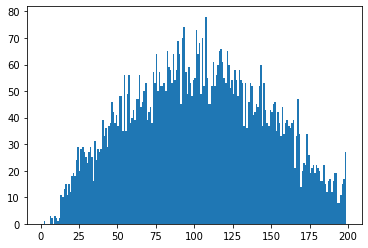

In [6]:
Len_Sentences = [len(x) for x in train_x]
binz = [x for x in range(1,200)]
plt.hist(Len_Sentences, bins=binz)

### Preprocessing data, Setup Dataloader

With this experiment, the data is random load for each batch, do not apply strategy same lenght sentences for each batch

Base on the distribution, the squence_lenght is set to average 100

In [7]:
tokenizer=tf.keras.preprocessing.text.Tokenizer(split=" ")
tokenizer.fit_on_texts(train_x+dev_x+test_x)

encoded_train =tokenizer.texts_to_sequences(train_x)
encoded_dev =tokenizer.texts_to_sequences(dev_x)
encoded_test =tokenizer.texts_to_sequences(test_x)


train_x = pad_text(encoded_train, seq_length = seqence_len)
train_y = np.array([1 if label == "pos" else 0 for label in train_y])


dev_x = pad_text(encoded_dev, seq_length = seqence_len)
dev_y = np.array([1 if label == "pos" else 0 for label in dev_y])


test_x = pad_text(encoded_test, seq_length = seqence_len)
test_y = np.array([1 if label == "pos" else 0 for label in test_y])


train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(dev_x), torch.from_numpy(dev_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = True)

In [8]:


embedding_matrix=create_embedding_matrix(tokenizer.word_index,embedding_dict=glove_embedding,dimension=embed_len)

# Models

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### CNN

In [10]:


class CNN(nn.Module):
    
    def __init__(self, n_vocab, n_embed, hidden_node, n_output, layers):
        super().__init__()

        self.embedding = nn.Embedding(n_vocab, n_embed)
        self.seq_len = 150
        self.fc_out = nn.Linear(300, n_output)
        
        self.conv = nn.Conv1d(in_channels=300, out_channels=100,kernel_size=3, padding=1)
        self.conv1 = nn.Conv1d(in_channels=300, out_channels=100,kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=100,kernel_size=7, padding=3)
        
        self.pooling = nn.MaxPool1d(150)
        
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(0.3)
        
    def forward (self, input_words):                                                        # => (batch size, sent len)

        batch = input_words.shape[0]
        seq_lenght= input_words.size(1)
        
        embedded_words = self.embedding(input_words)                                        # => (batch_size, seq_length, n_embed)
        embedded_words = embedded_words.permute(0,2,1)                                      # => (batch_size,  n_embed,seq_length)

        x = self.conv(embedded_words)           #[512, 100, 150]
        x = self.relu(x)
        x = self.pooling(x)                     #[512, 100, 1]
        
        x1 = self.conv1(embedded_words)
        x1 = self.relu(x1)
        x1 = self.pooling(x1)
        
        x2 = self.conv2(embedded_words)
        x2 = self.relu(x2)
        x2 = self.pooling(x2)
        
        out = self.fc_out(torch.cat(    (x.squeeze(), x1.squeeze(), x2.squeeze() )  , 1 )            )
        
        sig = self.sigmoid(out)
        return sig, x

# Training

### Hyper-parameter for tuning

In [11]:
n_vocab=embedding_matrix.shape[0]
n_embed=embedding_matrix.shape[1]
n_hidden = 512
n_output = 1   # 1 ("positive") or 0 ("negative")
layers = 1

### Init Training model

In [12]:

net = CNN(n_vocab, n_embed, n_hidden, n_output, layers).cuda()


criterion = nn.BCELoss()
criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr = 0.0001, weight_decay=0.0001)

# print(net)


In [13]:
step = 0
n_epochs = 80
clip = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
for epoch in range(n_epochs):
    
    for inputs, labels in train_loader:
        step += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        net.zero_grad()
        output, h = net(inputs)
        loss = criterion(output.squeeze(), labels.float())

        loss.backward()
        
        #To prevent exploding gradients
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if loss.item() < 0.02:
            break
        
        
        if (step % 50) == 0:            
            net.eval()
            valid_losses = []
            num_val_batch =0 
            for v_inputs, v_labels in valid_loader:
                num_val_batch += 1
                v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)

                
                v_output, v_h = net(v_inputs)
                v_loss = criterion(v_output.squeeze(), v_labels.float())
                valid_losses.append(v_loss.item())
               
            valid_losses = sum(valid_losses)/len(valid_losses)
                
            print("Epoch: {}/{}".format((epoch+1), n_epochs),
                  "Step: {}".format(step),
                  "Training Loss: {:.4f}".format(loss.item()),
                  "Validation Loss: {:.4f}".format(valid_losses),
                 )

            if valid_losses - loss.item() > 0.2:
                break
                
            net.train()
            
#torch.save(net.state_dict(), "LSTM.pt")


cuda


/opt/conda/envs/taco/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 4/80 Step: 50 Training Loss: 0.5984 Validation Loss: 0.6646
Epoch: 7/80 Step: 100 Training Loss: 0.5504 Validation Loss: 0.6447
Epoch: 10/80 Step: 150 Training Loss: 0.4741 Validation Loss: 0.6339
Epoch: 13/80 Step: 200 Training Loss: 0.4278 Validation Loss: 0.6187
Epoch: 16/80 Step: 250 Training Loss: 0.3746 Validation Loss: 0.6123
Epoch: 20/80 Step: 300 Training Loss: 0.3130 Validation Loss: 0.6039
Epoch: 24/80 Step: 350 Training Loss: 0.2756 Validation Loss: 0.5987
Epoch: 28/80 Step: 400 Training Loss: 0.2304 Validation Loss: 0.5918
Epoch: 32/80 Step: 450 Training Loss: 0.2035 Validation Loss: 0.5914
Epoch: 36/80 Step: 500 Training Loss: 0.1649 Validation Loss: 0.5899
Epoch: 40/80 Step: 550 Training Loss: 0.1351 Validation Loss: 0.5889
Epoch: 44/80 Step: 600 Training Loss: 0.1211 Validation Loss: 0.5877
Epoch: 48/80 Step: 650 Training Loss: 0.1038 Validation Loss: 0.5911
Epoch: 52/80 Step: 700 Training Loss: 0.0900 Validation Loss: 0.5838
Epoch: 56/80 Step: 750 Training Loss:

# Predict test

In [14]:
net.eval().to(device)
count = 0
sums = 0

for v_inputs, v_labels in test_loader:
    
    sums = sums + len(v_inputs)
    
    v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)

    v_output, v_h = net(v_inputs)
    
    v_loss = criterion(v_output.squeeze(), v_labels.float())
        

    output = torch.round(v_output.squeeze()).detach().cpu().numpy().astype(int)

    ground = v_labels.detach().cpu().numpy().astype(int)

    count = count + np.sum(output == ground)
    
print("Accuracy: " + str(count/len(test_x)))
print(len(test_x))
print(sums)

Accuracy: 0.6936292054402291
1397
1397


# Inference Sample

In [16]:
def inference(net, review, seq_length = 200):
    device = "cuda" #"cuda" if torch.cuda.is_available() else "cpu"
    
    text = review.lower()
    text = "".join([ch for ch in text if ch not in punctuation])
    words = text
    
    encoded_train =tokenizer.texts_to_sequences([words])
    padded_words = pad_text(encoded_train, seq_length = 200)
    padded_words = torch.from_numpy(padded_words).to(device)

    
    net.eval().to(device)
    output, h = net(padded_words )#, h)
    pred = torch.round(output.squeeze())  
    return pred

Test = [
    "It make me happy",
    "Unpleasant viewing experience",
    "I am interested with this assigment",
    "Poor you",
    "Happy new year"
]
for t in Test:
    lab = inference(net, t).tolist()
    if int(lab) == 0:
        print("negative:\t"+t)
    else:
        print("postive:\t"+t)
